In [263]:
import os
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, DataStructs
import ZMPY3D as zm
from pathlib import Path
from pyzernike import ZernikeDescriptor
import math
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import seaborn as sns
from rdkit.Chem import rdMolAlign
import plotly.graph_objects as go
from tqdm import tqdm
from rdkit import DataStructs
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats

In [264]:
sdf_file = '100_time_steps_generated_samples.sdf'

In [265]:
import pickle

MaxOrder=6

# Find the cache_data directory based on the site package location of ZMPY3D.
BinomialCacheFilePath=zm.__file__.replace('__init__.py', 'cache_data') + '/BinomialCache.pkl'
with open(BinomialCacheFilePath, 'rb') as file:
    BinomialCachePKL = pickle.load(file)

LogCacheFilePath=zm.__file__.replace('__init__.py', 'cache_data') + '/LogG_CLMCache_MaxOrder{:02d}.pkl'.format(MaxOrder)
with open(LogCacheFilePath, 'rb') as file:
    CachePKL = pickle.load(file)

BinomialCache=BinomialCachePKL['BinomialCache']

GCache_pqr_linear=CachePKL['GCache_pqr_linear']
GCache_complex=CachePKL['GCache_complex']
GCache_complex_index=CachePKL['GCache_complex_index']
CLMCache3D=CachePKL['CLMCache3D']
CLMCache=CachePKL['CLMCache']
RotationIndex=CachePKL['RotationIndex']

s_id=np.squeeze(RotationIndex['s_id'][0,0])-1
n   =np.squeeze(RotationIndex['n'][0,0])
l   =np.squeeze(RotationIndex['l'][0,0])
m   =np.squeeze(RotationIndex['m'][0,0])
mu  =np.squeeze(RotationIndex['mu'][0,0])
k   =np.squeeze(RotationIndex['k'][0,0])
IsNLM_Value=np.squeeze(RotationIndex['IsNLM_Value'][0,0])-1 

In [266]:
def OneTimeConversion(Voxel3D,Corner,GridWidth,BinomialCache, CLMCache, CLMCache3D, GCache_complex, GCache_complex_index, GCache_pqr_linear, MaxOrder, Param):
    
    Dimension_BBox_scaled=Voxel3D.shape

    XYZ_SampleStruct = {
        'X_sample': np.arange(Dimension_BBox_scaled[0] + 1),
        'Y_sample': np.arange(Dimension_BBox_scaled[1] + 1),
        'Z_sample': np.arange(Dimension_BBox_scaled[2] + 1)
    }

    # Calculate the volume mass and the center of mass
    [VolumeMass,Center,_]=zm.calculate_bbox_moment(Voxel3D,1,XYZ_SampleStruct)

    [AverageVoxelDist2Center,MaxVoxelDist2Center]=zm.calculate_molecular_radius(Voxel3D,Center,VolumeMass,Param['default_radius_multiplier'])

    Center_scaled=Center*GridWidth+Corner

    ##################################################################################
    # You may add any preprocessing on the voxel before applying the Zernike moment. #
    ##################################################################################

    # Calculate the weights for sphere sampling    
    SphereXYZ_SampleStruct=zm.get_bbox_moment_xyz_sample(Center,AverageVoxelDist2Center,Dimension_BBox_scaled)

    # Apply weights to the geometric moments
    _,_,SphereBBoxMoment=zm.calculate_bbox_moment(Voxel3D,MaxOrder,SphereXYZ_SampleStruct)

    # Convert to unscaled 3D Zernike moments
    [_, ZMoment_raw]=zm.calculate_bbox_moment_2_zm(MaxOrder, GCache_complex, GCache_pqr_linear, GCache_complex_index, CLMCache3D, SphereBBoxMoment)

    # Calculate alternative 3D Zernike moments for specific normalisation orders 2, 3, 4, 5 and 6
    ABList_2=zm.calculate_ab_rotation_all(ZMoment_raw, 2)
    ABList_3=zm.calculate_ab_rotation_all(ZMoment_raw, 3)
    ABList_4=zm.calculate_ab_rotation_all(ZMoment_raw, 4)
    ABList_5=zm.calculate_ab_rotation_all(ZMoment_raw, 5)
    ABList_6=zm.calculate_ab_rotation_all(ZMoment_raw, 6)

    ABList_all=np.vstack(ABList_2+ABList_3+ABList_4+ABList_5+ABList_6)

    ZMList_all=zm.calculate_zm_by_ab_rotation(ZMoment_raw, BinomialCache, ABList_all, MaxOrder, CLMCache,s_id,n,l,m,mu,k,IsNLM_Value)
    
    ZMList_all=np.stack(ZMList_all,axis=3)

    ZMList_all=np.transpose(ZMList_all,(2,1,0,3))
    ZMList_all=ZMList_all[~np.isnan(ZMList_all)]
    
    # Based on ABList_all, it is known in advance that Order 6 will definitely have 96 pairs of AB, which means 96 vectors.
    ZMList_all=np.reshape(ZMList_all,(np.int64(ZMList_all.size/96),96)) 

    return Center_scaled, ABList_all,ZMList_all


print(f"Merge all steps into a single callable function, OneTimeConversion, generating alternative 3D Zernike moments for rotational variations")
 

Merge all steps into a single callable function, OneTimeConversion, generating alternative 3D Zernike moments for rotational variations


In [267]:
Param = {
    'default_radius_multiplier': 1.6,
}

In [268]:
def get_molecule_params_and_coords2(mol):
    """
    Извлекает координаты и уникальные свойства атомов из объекта RDKit mol.
    """
    pt = Chem.GetPeriodicTable()
    
    # 1. Получаем координаты
    conf = mol.GetConformer()
    xyz = conf.GetPositions()
    
    # 2. Собираем данные об атомах
    atom_symbols = []
    unique_elements = set()
    
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        atom_symbols.append(symbol)
        unique_elements.add(symbol)
        
    # 3. Генерируем карты весов и радиусов только для присутствующих элементов
    # Коэффициент sqrt(5/3) взят из вашего исходного кода для белков #math.sqrt(5.0 / 3.0)
    
    radius_map = {}
    
    for symbol in unique_elements:
        # Ван-дер-Ваальсов радиус * ваш коэффициент
        radius_map[symbol] = pt.GetRvdw(symbol)
        
    return xyz, atom_symbols, radius_map

In [269]:
def create_hard_voxel_from_sdf(mol, grid_width=0.2):
    # 1. Загрузка и подготовка
    if mol.GetNumConformers() == 0:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())

    pt = Chem.GetPeriodicTable()
    conf = mol.GetConformer()
    xyz = conf.GetPositions()
    
    # Реальный физический центр масс (в Ангстремах)
    center_mass = np.mean(xyz, axis=0)
    # Центрируем координаты для вокселизации
    xyz_centered = xyz - center_mass
    
    # 2. Определение размеров куба
    max_dist = np.max(np.linalg.norm(xyz_centered, axis=1))
    cube_side_angstrom = (max_dist + 3.0) * 2
    cube_size = int(np.ceil(cube_side_angstrom / grid_width))
    
    voxel_cube = np.zeros((cube_size, cube_size, cube_size), dtype=np.float32)
    # Индекс центрального вокселя
    grid_center = cube_size // 2

    # --- ВОТ ТУТ СЧИТАЕМ CORNER ---
    # Это координата [0,0,0] вокселя в реальном пространстве SDF-файла
    corner_xyz = center_mass - (grid_center * grid_width)
    # ------------------------------

    # 3. Заполнение "шариков"
    for i, atom in enumerate(mol.GetAtoms()):
        symbol = atom.GetSymbol()
        weight = 1.0 # Либо pt.GetAtomicWeight(symbol)
        radius = pt.GetRvdw(symbol) * 0.8
        
        # Позиция центра атома в индексах сетки
        atom_grid_pos = np.round(xyz_centered[i] / grid_width).astype(int) + grid_center
        
        r_vox = int(np.ceil(radius / grid_width))
        z, y, x = np.ogrid[-r_vox : r_vox+1, -r_vox : r_vox+1, -r_vox : r_vox+1]
        dist_sq = (x**2 + y**2 + z**2) * (grid_width**2)
        mask = dist_sq <= (radius**2)
        
        # Границы вставки (защиту от выхода за края массива лучше оставить)
        z_s, z_e = atom_grid_pos[0]-r_vox, atom_grid_pos[0]+r_vox+1
        y_s, y_e = atom_grid_pos[1]-r_vox, atom_grid_pos[1]+r_vox+1
        x_s, x_e = atom_grid_pos[2]-r_vox, atom_grid_pos[2]+r_vox+1
        
        # Вставляем значения
        voxel_cube[z_s:z_e, y_s:y_e, x_s:x_e][mask] = weight

    return voxel_cube, corner_xyz

In [270]:
'''def load_molecules_from_sdf(filepath, max_molecules=None, removeHs=False, sanitize=True, start_from=0):
    
    molecules = []
    supplier = Chem.SDMolSupplier(filepath, removeHs=removeHs, sanitize=sanitize)
    mol: Chem.Mol

    print(f"Загрузка молекул из: {filepath}")
    print(f"Общее количество молекул в файле: {len(supplier)}")
    print(f"Начало загрузки с индекса: {start_from}")
    
    i = start_from
    max_molecules = max_molecules - start_from
    loaded_count = 0
    for i, mol in enumerate(supplier):
        if i < start_from:
            continue
        if max_molecules is not None and loaded_count >= max_molecules:
            break
            
        if mol is not None:
            molecules.append(mol)   
            loaded_count += 1
    
   
    
    return molecules'''

'def load_molecules_from_sdf(filepath, max_molecules=None, removeHs=False, sanitize=True, start_from=0):\n\n    molecules = []\n    supplier = Chem.SDMolSupplier(filepath, removeHs=removeHs, sanitize=sanitize)\n    mol: Chem.Mol\n\n    print(f"Загрузка молекул из: {filepath}")\n    print(f"Общее количество молекул в файле: {len(supplier)}")\n    print(f"Начало загрузки с индекса: {start_from}")\n\n    i = start_from\n    max_molecules = max_molecules - start_from\n    loaded_count = 0\n    for i, mol in enumerate(supplier):\n        if i < start_from:\n            continue\n        if max_molecules is not None and loaded_count >= max_molecules:\n            break\n\n        if mol is not None:\n            molecules.append(mol)   \n            loaded_count += 1\n\n\n\n    return molecules'

In [271]:
import random

def load_random_molecules_from_sdf(sdf_file, n, seed=None):
    if seed is not None:
        random.seed(seed)
    
    supplier = Chem.SDMolSupplier(sdf_file)
    total = len(supplier)
    
    random_indices = random.sample(range(total), n)
    
    molecules = []
    for idx in random_indices:
        mol = supplier[idx]
        if mol is not None:
            molecules.append(mol)
    
    return molecules

In [272]:
#molecules = load_molecules_from_sdf(sdf_file, max_molecules=200, start_from=0)
molecules = load_random_molecules_from_sdf(sdf_file, n=300, seed=45)

In [273]:
GridWidth = 1.0

results = [(get_molecule_params_and_coords2(mol),
            create_hard_voxel_from_sdf(mol))
           for mol in molecules]

xyz, all_atom_lists, radius_maps, voxelcubes, corners = zip(*[
    ((params[0], params[1], params[2], voxel[0], voxel[1]))
    for params, voxel in results
])

In [274]:

ZMList_All = []
for i in tqdm(range(len(molecules)), desc="Processing molecules", unit="mol"):
    _, _, zma_result = OneTimeConversion(voxelcubes[i], corners[i], GridWidth, BinomialCache, CLMCache, CLMCache3D, GCache_complex, GCache_complex_index, GCache_pqr_linear, MaxOrder, Param)
    ZMList_All.append(zma_result)

Processing molecules: 100%|██████████| 300/300 [00:06<00:00, 44.83mol/s] 


In [275]:
def visualize_voxels_overlay(voxels_list, titles=None, colorscales=None, 
                            opacities=None, isomin_factor=0.3, isomax_factor=0.5):
    """
    Визуализация вокселей с наложением (для сравнения).
    
    Параметры:
    - voxels_list: список 3D numpy массивов
    - titles: список заголовков
    - colorscales: список цветовых схем
    - opacities: список значений прозрачности
    """
    if titles is None:
        titles = [f"Voxel {i+1}" for i in range(len(voxels_list))]
    
    if colorscales is None:
        colorscales = ['viridis', 'plasma', 'thermal', 'rainbow', 'portland'][:len(voxels_list)]
    
    if opacities is None:
        opacities = [0.35 + i * 0.1 for i in range(len(voxels_list))]
    
    fig = go.Figure()
    
    for idx, voxel in enumerate(voxels_list):
        # Создаем координатную сетку
        x, y, z = np.meshgrid(
            np.arange(voxel.shape[0]),
            np.arange(voxel.shape[1]),
            np.arange(voxel.shape[2]),
            indexing='ij'
        )
        
        # Преобразуем в 1D массивы
        x_flat = x.flatten()
        y_flat = y.flatten()
        z_flat = z.flatten()
        values_flat = voxel.flatten()
        
        # Добавляем изоповерхность
        fig.add_trace(go.Isosurface(
            x=x_flat,
            y=y_flat,
            z=z_flat,
            value=values_flat,
            isomin=voxel.mean() * isomin_factor,
            isomax=voxel.max() * isomax_factor,
            surface_count=2,
            opacity=opacities[idx],
            caps=dict(x_show=False, y_show=False, z_show=False),
            colorscale=colorscales[idx],
            name=titles[idx],
            showlegend=True
        ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectratio=dict(x=1.5, y=1.5, z=1.5)
        ),
        title="3D Voxel Comparison (Overlay)",
        legend_title="Molecules",
        width=1000,
        height=700
    )
    
    fig.show()

In [276]:
#visualize_voxels_overlay(voxel_lst)

---

In [277]:
def calculate_zernike_similarity(ZMList_A, ZMList_B):
    """
    Вычисляет максимальное нормализованное сходство между двумя наборами 
    дескрипторов моментов Цернике.
    
    ZMList: матрицы размера (количество_коэффициентов, количество_ротаций)
    """
    
    # 1. Вычисляем матрицу скалярных произведений (как в вашем коде)
    # Используем абсолютное значение, так как моменты комплексные
    M = np.abs(ZMList_A.conj().T @ ZMList_B)
    
    # 2. Находим индексы максимального совпадения
    idx_a, idx_b = np.unravel_index(np.argmax(M), M.shape)
    max_val = M[idx_a, idx_b]
    
    # 3. Вычисляем нормы векторов, которые дали этот максимум
    # Нам нужны конкретные столбцы (или строки), соответствующие индексам
    norm_a = np.linalg.norm(ZMList_A[:, idx_a])
    norm_b = np.linalg.norm(ZMList_B[:, idx_b])
    
    # 4. Финальный Similarity Score (Косинусное сходство)
    similarity_score = max_val / (norm_a * norm_b)
    
    return similarity_score, (idx_a, idx_b)

In [278]:
'''def compare_first_vector(matrix1, matrix2):
    """
    Сравнивает только первые векторы-дескрипторы (первый столбец) двух матриц.
    """
    vector1 = matrix1[:, 0]
    vector2 = matrix2[:, 0]
    
    dist = np.linalg.norm(vector1 - vector2)
    return dist'''

'def compare_first_vector(matrix1, matrix2):\n    """\n    Сравнивает только первые векторы-дескрипторы (первый столбец) двух матриц.\n    """\n    vector1 = matrix1[:, 0]\n    vector2 = matrix2[:, 0]\n\n    dist = np.linalg.norm(vector1 - vector2)\n    return dist'

In [279]:
molecules_3d = []
for i in range(len(molecules)):
    mol = Chem.AddHs(molecules[i], addCoords=True) 
    AllChem.UFFOptimizeMolecule(mol, maxIters=200)
    molecules_3d.append(mol)


In [280]:
def compare_rdkit_3d_euclidean(mol1, mol2):
    """
    Сравнение через USR дескрипторы (L2 дистанция).
    """
    # Генерируем 3D-дескрипторы
    fp1 = rdMolDescriptors.GetUSR(mol1)
    fp2 = rdMolDescriptors.GetUSR(mol2)
    
    # Считаем евклидово расстояние
    dist = np.linalg.norm(np.array(fp1) - np.array(fp2))
    return dist

In [281]:
from rdkit.Chem import rdShapeHelpers

def _ensure_3d(molecules):
    mol_list = []
    for mol in molecules: 
        m = Chem.Mol(mol)
        m = Chem.AddHs(m, addCoords=True)
        if m.GetNumConformers() == 0:
            raise ValueError("zero conformers")
        mol_list.append(m)
    return mol_list


def shape_tanimoto_3d(molecules):

    shape_score_list = []
    m_list = _ensure_3d(molecules)

    for i in range(len(m_list) - 1):

        m1 = Chem.Mol(m_list[i])
        m2 = Chem.Mol(m_list[i + 1])
        dist = rdShapeHelpers.ShapeTanimotoDist(m1, m2)

        shape_score_list.append(float(1 - dist))

    return shape_score_list


In [282]:
def atom_difference(m1, m2):
    return abs(m1.GetNumAtoms() - m2.GetNumAtoms())

In [283]:
from rdkit.Chem import rdShapeAlign
from rdkit.Chem import rdShapeHelpers
pair_ids = []
dist_zernike_list = []
dist_rdkit_eucl_list = []
dist_rdkit_tani_list = []
dist_ZerRd_list = []
atom_diff_list=[]
m_list = _ensure_3d(molecules)

for i in range(len(molecules)):
    for j in range(i + 1, len(molecules)):
        pair_id = f"{i}_{j}"
        pair_ids.append(pair_id)



        atom_diff = atom_difference(molecules[i], molecules[j])
        atom_diff_list.append(atom_diff)

        # 1. Zernike
        d_z, _ = calculate_zernike_similarity(ZMList_All[i], ZMList_All[j])
        dist_zernike_list.append(1 - d_z)

        # 2. RDKit USR
        d_e = compare_rdkit_3d_euclidean(molecules[i], molecules[j])
        dist_rdkit_eucl_list.append(d_e)

        # 3. Shape Tanimoto
        m1 = Chem.Mol(m_list[i])
        m2 = Chem.Mol(m_list[j])
        rdShapeAlign.AlignMol(m2, m1)
        dist = rdShapeHelpers.ShapeTanimotoDist(m1, m2)
        dist_rdkit_tani_list.append(1.0 - dist)

        d_mean = d_z + d_e*0.1
        dist_ZerRd_list.append(d_mean)

df_results = pd.DataFrame({
    'id': pair_ids,
    'zernike': dist_zernike_list,
    'rdkit': dist_rdkit_eucl_list,
    'tanimoto': dist_rdkit_tani_list,
    'atom_diff': atom_diff_list
})

df_results['combined'] = df_results['zernike'] + 0.1 * df_results['rdkit']
df_small = df_results[df_results['atom_diff'] <= 4].copy()

# Вывод первых строк для проверки
print(df_results.head())


    id   zernike     rdkit  tanimoto  atom_diff  combined
0  0_1  0.221350  3.469747  0.432605          3  0.568325
1  0_2  0.190535  1.081026  0.419699          2  0.298638
2  0_3  0.170403  2.415452  0.456025          5  0.411948
3  0_4  0.177239  3.981255  0.407200          5  0.575365
4  0_5  0.136893  4.716185  0.439507          9  0.608511


In [284]:
# Создаем DataFrame из ваших списков
data = {
    'Zernike_Dist': dist_zernike_list,
    'RDKit_USR_Dist': dist_rdkit_eucl_list,
    'RDKit_Tanimoto_Sim': dist_rdkit_tani_list
}

df = pd.DataFrame(data)

spearman_corr = df.corr(method='spearman')

print("\nSpearman corelation:")
print(spearman_corr)

print("corr(combined, tanimoto)=", df_results['combined'].corr(df_results['tanimoto']))


Spearman corelation:
                    Zernike_Dist  RDKit_USR_Dist  RDKit_Tanimoto_Sim
Zernike_Dist            1.000000        0.220240           -0.359216
RDKit_USR_Dist          0.220240        1.000000           -0.612654
RDKit_Tanimoto_Sim     -0.359216       -0.612654            1.000000
corr(combined, tanimoto)= -0.6763376666722736


In [285]:

print("\nAtom diff ≤ 5:")
print(df_small[['zernike','rdkit','tanimoto']].corr())


Atom diff ≤ 5:
           zernike     rdkit  tanimoto
zernike   1.000000  0.320477 -0.394937
rdkit     0.320477  1.000000 -0.619468
tanimoto -0.394937 -0.619468  1.000000


In [286]:
def compute_pair_size(df):
    sizes = []
    
    for pair_id in df['id']:
        i, j = map(int, pair_id.split('_'))
        n_i = m_list[i].GetNumAtoms()
        n_j = m_list[j].GetNumAtoms()
        
        sizes.append((n_i + n_j) / 2)  # средний размер
    
    return sizes

df_small['pair_size'] = compute_pair_size(df_small)
df_results['pair_size'] = compute_pair_size(df_results)

In [287]:
threshold = df_small['pair_size'].median()
print("Threshold (median size):", threshold)
small_pairs = df_small[df_small['pair_size'] <= 50]
large_pairs = df_small[df_small['pair_size'] > 50]

print("Small pairs:", len(small_pairs))
print("Large pairs:", len(large_pairs))
corr_small = small_pairs['zernike'].corr(small_pairs['tanimoto'])
corr_large = large_pairs['zernike'].corr(large_pairs['tanimoto'])

print("Correlation (small molecules):", corr_small)
print("Correlation (large molecules):", corr_large)

Threshold (median size): 52.5
Small pairs: 8443
Large pairs: 13248
Correlation (small molecules): -0.4154961093682162
Correlation (large molecules): -0.3635574846961639


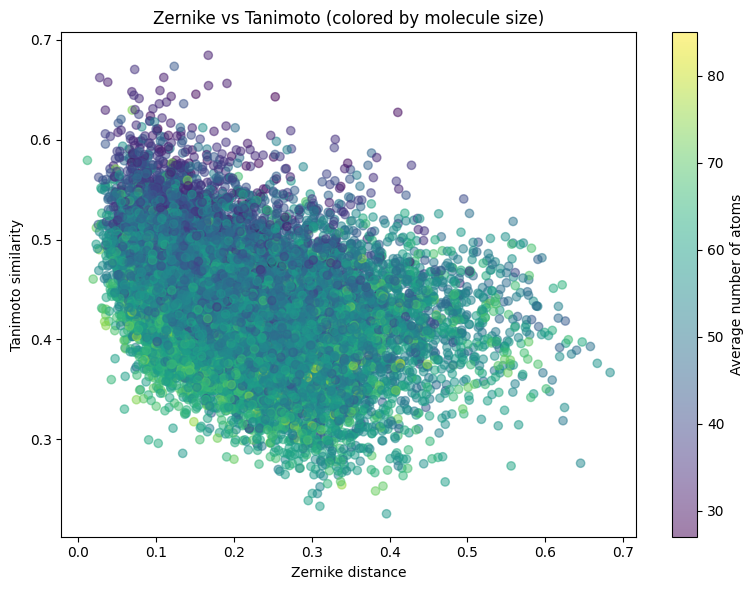

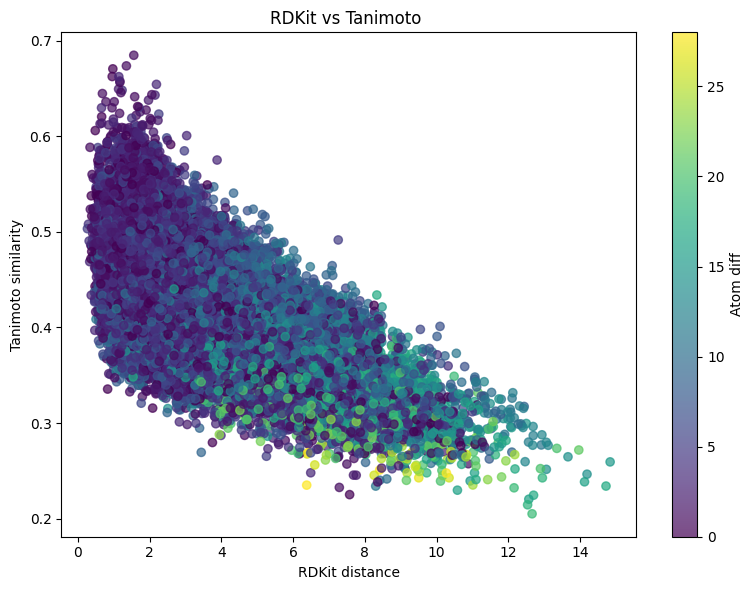

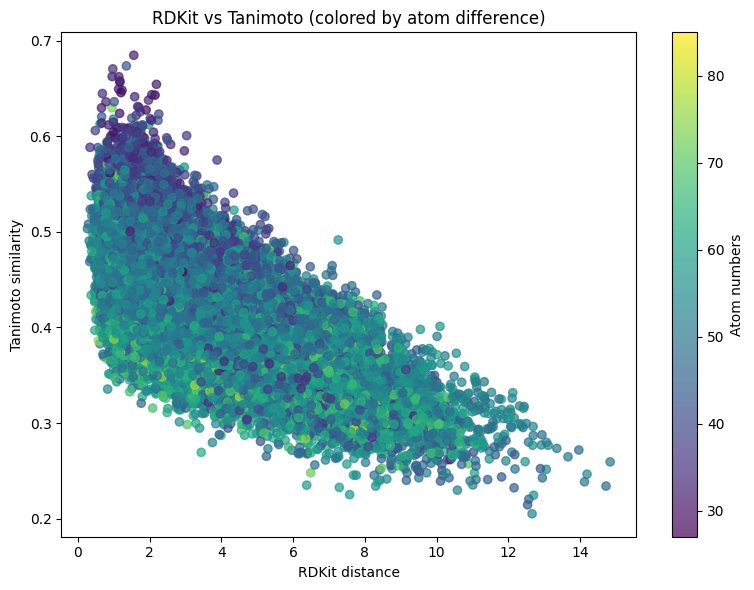

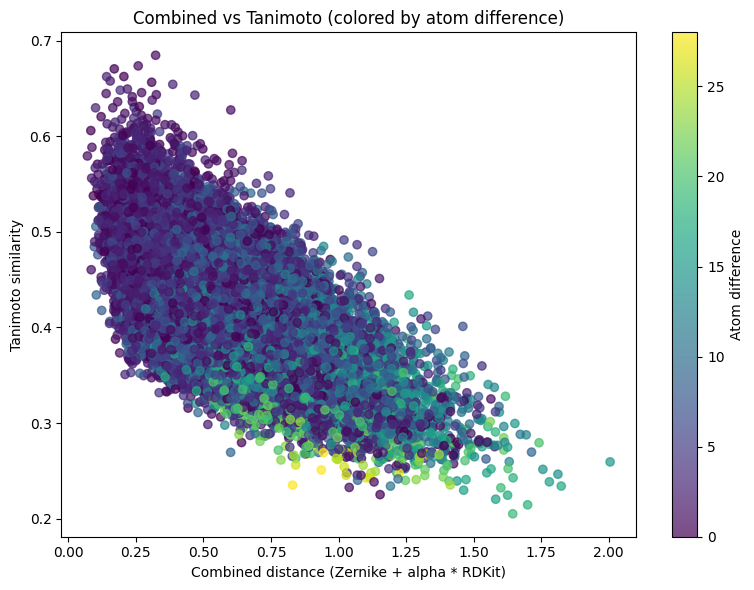

In [288]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    df_small['zernike'],
    df_small['tanimoto'],
    c=df_small['pair_size'],
    cmap='viridis',
    alpha=0.5
)

plt.xlabel('Zernike distance')
plt.ylabel('Tanimoto similarity')
plt.title('Zernike vs Tanimoto (colored by molecule size)')

cbar = plt.colorbar(scatter)
cbar.set_label('Average number of atoms')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    df_results['rdkit'],
    df_results['tanimoto'],
    c=df_results['atom_diff'],
    cmap='viridis',
    alpha=0.7
)

plt.xlabel('RDKit distance')
plt.ylabel('Tanimoto similarity')
plt.title('RDKit vs Tanimoto ')

cbar = plt.colorbar(scatter)
cbar.set_label('Atom diff')

plt.tight_layout()
plt.show()
plt.figure(figsize=(8,6))

scatter = plt.scatter(
    df_results['rdkit'],
    df_results['tanimoto'],
    c=df_results['pair_size'],
    cmap='viridis',
    alpha=0.7
)

plt.xlabel('RDKit distance')
plt.ylabel('Tanimoto similarity')
plt.title('RDKit vs Tanimoto (colored by atom difference)')

cbar = plt.colorbar(scatter)
cbar.set_label('Atom numbers')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    df_results['combined'],
    df_results['tanimoto'],
    c=df_results['atom_diff'],
    cmap='viridis',
    alpha=0.7
)

plt.xlabel('Combined distance (Zernike + alpha * RDKit)')
plt.ylabel('Tanimoto similarity')
plt.title(f'Combined vs Tanimoto (colored by atom difference)')

cbar = plt.colorbar(scatter)
cbar.set_label('Atom difference')

plt.tight_layout()
plt.show()


In [302]:
bad_pairs = df_results[
    ((df_results['tanimoto'] > 0.6) & (df_results['zernike'] > 0.7)) |
    ((df_results['tanimoto'] < 0.50) & (df_results['zernike'] < 0.5))
]

bad_pairs_RDkit = df_results[
    ((df_results['tanimoto'] > 0.6) & (df_results['rdkit'] > 14)) |
    ((df_results['tanimoto'] < 0.60) & (df_results['rdkit'] < 8))
]
print(bad_pairs.head())

    id   zernike     rdkit  tanimoto  atom_diff  combined  pair_size
0  0_1  0.221350  3.469747  0.432605          3  0.568325       51.5
1  0_2  0.190535  1.081026  0.419699          2  0.298638       51.0
2  0_3  0.170403  2.415452  0.456025          5  0.411948       49.0
3  0_4  0.177239  3.981255  0.407200          5  0.575365       52.5
4  0_5  0.136893  4.716185  0.439507          9  0.608511       43.0


In [304]:
set_z = set(bad_pairs['id'])
set_r = set(bad_pairs_RDkit['id'])

print("bad_pairs (Zernike):", len(set_z))
print("bad_pairs (RDKit):", len(set_r))
print("Intersection:", len(set_z & set_r))
print("Only Zernike:", len(set_z - set_r))
print("Only RDKit:", len(set_r - set_z))

bad_pairs (Zernike): 40929
bad_pairs (RDKit): 43505
Intersection: 39668
Only Zernike: 1261
Only RDKit: 3837


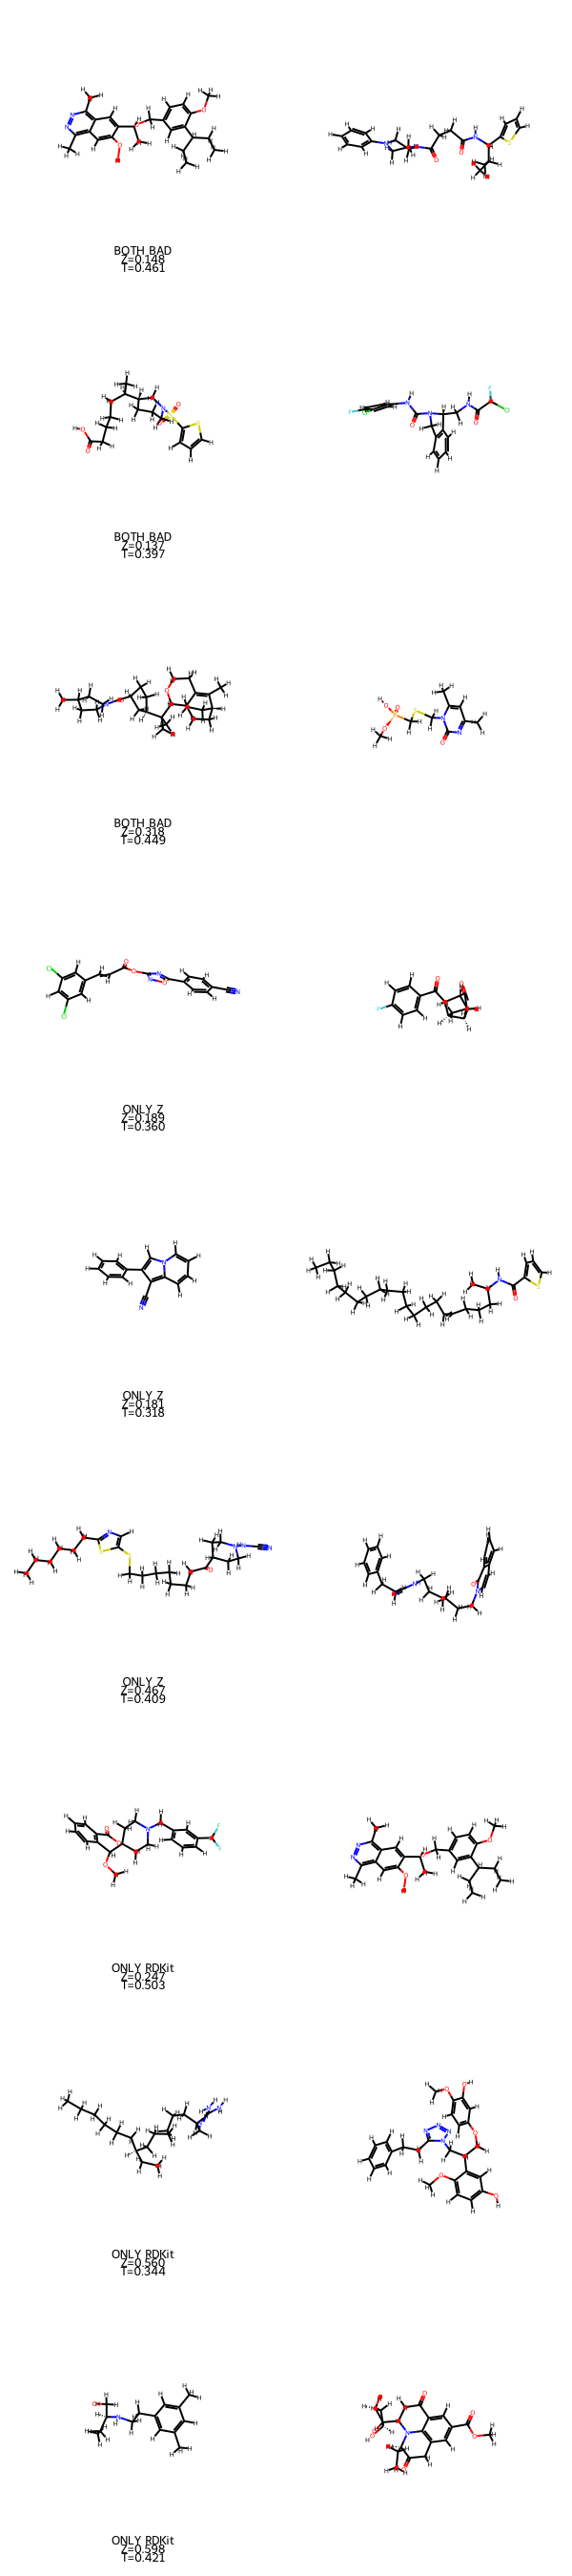

In [307]:
set_z = set(bad_pairs['id'])
set_r = set(bad_pairs_RDkit['id'])

both_bad = df_results[df_results['id'].isin(set_z & set_r)]
only_z   = df_results[df_results['id'].isin(set_z - set_r)]
only_r   = df_results[df_results['id'].isin(set_r - set_z)]

def show_random_pairs(df, n=5, title=""):
    if len(df) == 0:
        print(f"{title}: empty")
        return
    
    sample = df.sample(min(n, len(df)), random_state=42)
    
    print(title)
    display(show_pairs_with_metrics(sample, n=len(sample)))

def show_all_categories_one_image(n=3):
    dfs = []
    
    categories = [
        (both_bad, "BOTH BAD"),
        (only_z,   "ONLY Z"),
        (only_r,   "ONLY RDKit"),
        
    ]
    
    for df, label in categories:
        if len(df) == 0:
            continue
        
        sample = df.sample(min(n, len(df)), random_state=42).copy()
        sample["category"] = label
        dfs.append(sample)
    
    combined = pd.concat(dfs, ignore_index=True)
    
    # ---------- строим одну картинку ----------
    mols = []
    legends = []
    
    for _, row in combined.iterrows():
        pair_id = row['id']
        i, j = map(int, pair_id.split('_'))
        
        z = row['zernike']
        t = row['tanimoto']
        cat = row['category']
        
        mols.append(m_list[i])
        mols.append(m_list[j])
        
        label = f"{cat}\nZ={z:.3f}\nT={t:.3f}"
        
        legends.append(label)
        legends.append("")
    
    return Draw.MolsToGridImage(
        mols,
        molsPerRow=2,
        legends=legends,
        subImgSize=(300, 300)
    )
display(show_all_categories_one_image(n=3))

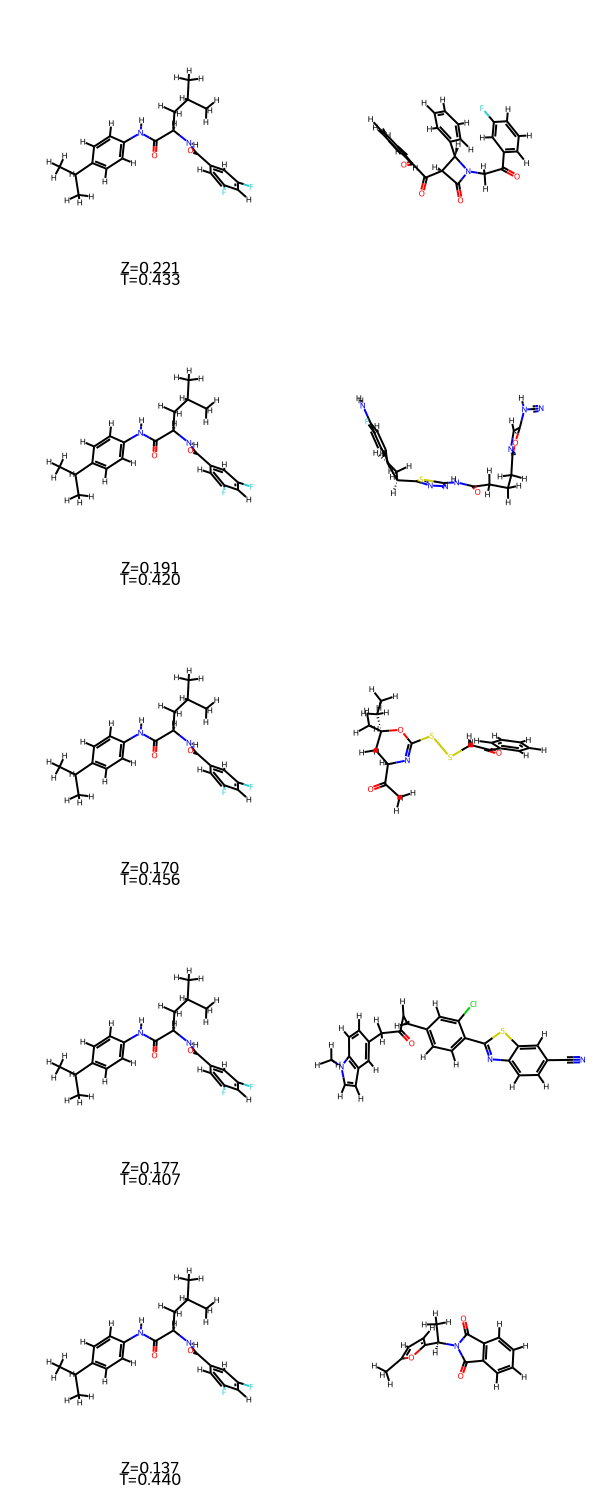

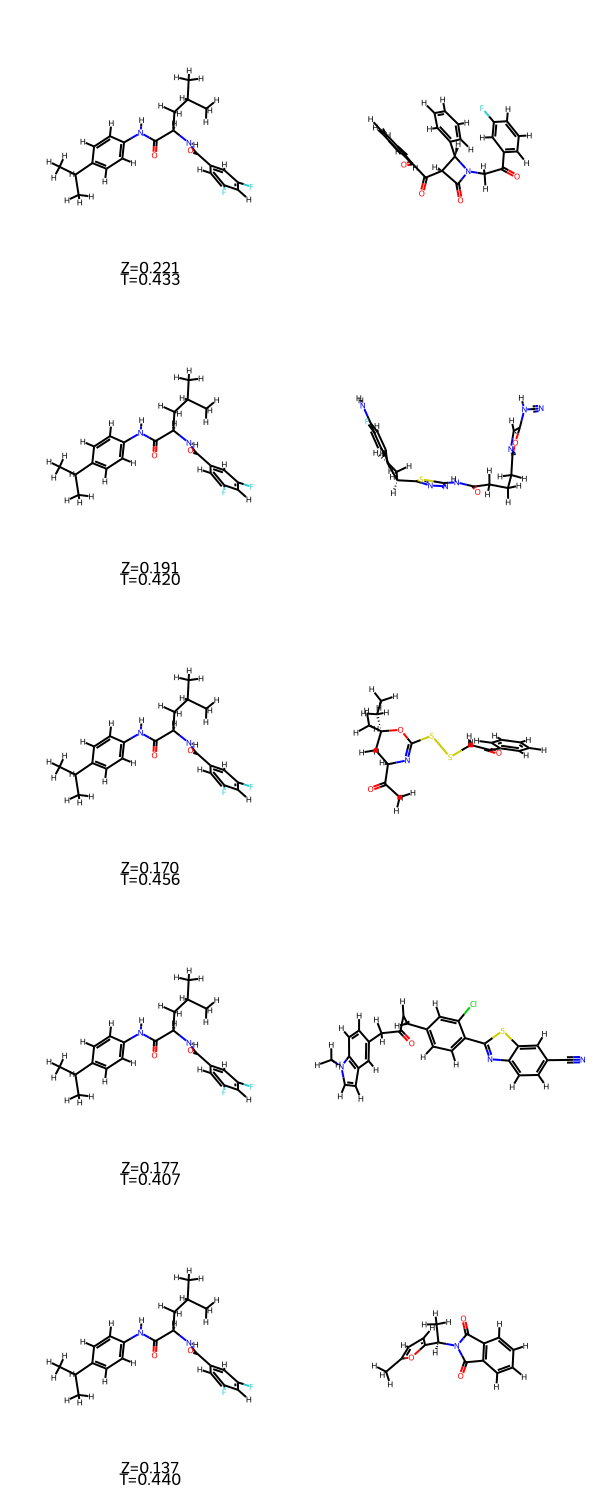

In [301]:
from rdkit.Chem import Draw

def show_pairs_with_metrics(df, n=5):
    mols = []
    legends = []
    
    for idx in range(n):
        row = df.iloc[idx]
        
        pair_id = row['id']
        i, j = map(int, pair_id.split('_'))
        
        z = row['zernike']
        t = row['tanimoto']
        
        mols.append(m_list[i])
        mols.append(m_list[j])
        
        label = f"Z={z:.3f}\nT={t:.3f}"
        
        legends.append(label)
        legends.append('')
       
       
    
    return Draw.MolsToGridImage(
        mols,
        molsPerRow=2,
        legends=legends,
        subImgSize=(300, 300)
    )
display(show_pairs_with_metrics(bad_pairs, n=5))
display(show_pairs_with_metrics(bad_pairs_RDkit, n=5))


         id   zernike     rdkit  tanimoto  atom_diff  combined  pair_size
1493   5_14  0.068599  1.234856  0.648041          4  0.192084       32.5
1553   5_74  0.104770  1.137196  0.649262          2  0.218490       32.0
1671  5_192  0.113118  1.970728  0.637654          2  0.310191       34.0
1672  5_193  0.146287  0.856702  0.611771          2  0.231957       32.5
1748  5_269  0.107479  1.627376  0.621763          1  0.270216       34.5
Количество хороших пар: 60


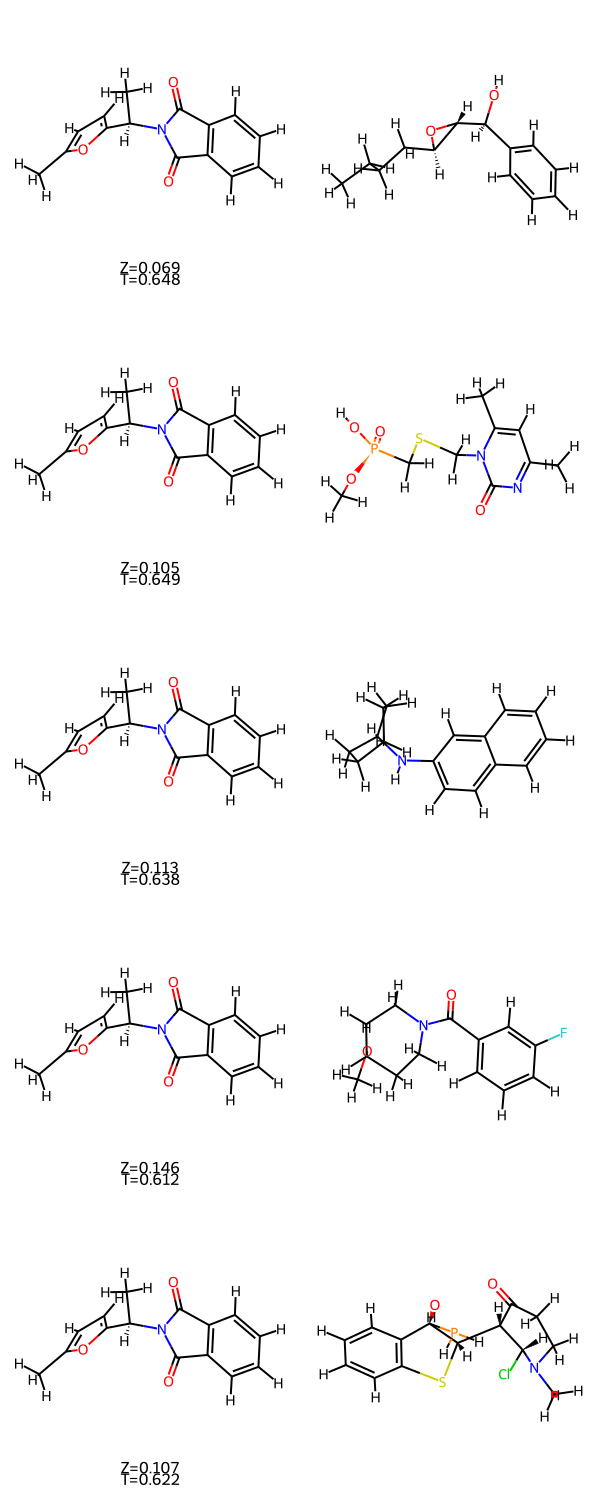

In [291]:
good_pairs = df_results[
    (df_results['tanimoto'] > 0.6) &
    (df_results['zernike'] < 0.2)
].copy()

print(good_pairs.head())
print("Количество хороших пар:", len(good_pairs))
show_pairs_with_metrics(good_pairs, n=5)

In [292]:
# 1. Расчет дополнительных коэффициентов
def calculate_advanced_stats(df):
    results = []
    pairs = [('Zernike_Dist', 'RDKit_USR_Dist'), 
             ('Zernike_Dist', 'RDKit_Tanimoto_Sim'),
             ('RDKit_USR_Dist', 'RDKit_Tanimoto_Sim')]
    
    for c1, c2 in pairs:
        # Spearman
        rho, s_p = spearmanr(df[c1], df[c2])
        
        
        results.append({
            'Pair': f"{c1} vs {c2}",
            'Spearman_Rho': rho,
            
        })
    
    return pd.DataFrame(results)

advanced_df = calculate_advanced_stats(df)
print(advanced_df)


                                   Pair  Spearman_Rho
0        Zernike_Dist vs RDKit_USR_Dist      0.220240
1    Zernike_Dist vs RDKit_Tanimoto_Sim     -0.359216
2  RDKit_USR_Dist vs RDKit_Tanimoto_Sim     -0.612654
